# 目的
勾配を用いない最適化法であるCMA-ESを利用している応用側の研究者から，「CMA-ESを用いてみたが，望ましい解が得られない」といった相談やコメントをしばしばいただきます．ここでは，CMA-ESをうまく活用するための設定，実験結果から問題の性質についての分析，問題定式化の検討の観点から，私の経験則をまとめます．

# 参考資料
この資料は，著者らが毎年国際会議GECCOにおいて開催しているCMA-ESチュートリアルを参考にしています．

Youhei Akimoto and Nikolaus Hansen. 2022. CMA-ES and advanced adaptation mechanisms. In Proceedings of the Genetic and Evolutionary Computation Conference Companion (GECCO '22). Association for Computing Machinery, New York, NY, USA, 1243–1268. https://doi.org/10.1145/3520304.3533648
チュートリアル動画：https://www.youtube.com/watch?v=7VBKLH3oDuw






# プログラム
このチュートリアルでは，著者らが公開している最新のCMA-ESの実装である，DD-CMA-ESを用いています．

Y. Akimoto and N. Hansen. 
    Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies
    Evolutionary Computation (2020) 28(3): 405--435.
コード：https://gist.github.com/youheiakimoto/1180b67b5a0b1265c204cba991fa8518

In [2]:
# LaTeX コマンドを読み込むための準備（可視化用，1min程度）
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal dvisvgm fonts-droid-fallback fonts-lato fonts-lmodern
  fonts-noto-mono fonts-texgyre fonts-urw-base35 ghostscript javascript-common
  libapache-pom-java libcommons-logging-java libcommons-parent-java
  libfontbox-java libgs9 libgs9-common libidn11 libijs-0.35 libjbig2dec0
  libjs-jquery libkpathsea6 libpdfbox-java libptexenc1 libruby2.7 libsynctex2
  libteckit0 libtexlua53 libtexluajit2 libzzip-0-13 lmodern pfb2t1c2pfb
  poppler-data preview-latex-style rake ruby ruby-minitest ruby-net-telnet
  ruby-power-assert ruby-test-unit ruby-xmlrpc ruby2.7 rubygems-integration
  t1utils tex-common tex-gyre texlive-base texlive-binaries
  texlive-fonts-recommended texlive-latex-base texlive-pictures
  texlive-plain-generic tipa xfonts-encodings xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf g

In [3]:
# https://gist.github.com/youheiakimoto/1180b67b5a0b1265c204cba991fa8518 のコピー
import warnings
from collections import deque
import math
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

class DdCma:
    """dd-CMA: CMA-ES with diagonal decoding [1]
    Note
    ----
    If you are interested in constrained optimization and/or multi-fidelity optimization,
    check the following repository:
    https://github.com/akimotolab/multi-fidelity
    
    History
    -------
    2022/03/24: Mirroring box constraint handling and periodic variable handling [3] have been implemented.
    2020/06/10: Restart (IPOP mechanism) [2] has been implemented.
    2019/03/23: release
    Reference
    ---------
    [1] Y. Akimoto and N. Hansen. 
    Diagonal Acceleration for Covariance Matrix Adaptation Evolution Strategies
    Evolutionary Computation (2020) 28(3): 405--435.
    [2] A. Auger and N. Hansen.
    A Restart CMA Evolution Strategy With Increasing Population Size
    IEEE Congress on Evolutionary Computation (2005): 1769-1776.
    [3] Y. Yamaguchi and A. Akimoto.
    A Note on the CMA-ES for Functions with Periodic Variables
    Genetic and Evolutionary Computation Conference Companion (2018): 227-228.
    """
    
    def __init__(self, xmean0, sigma0, 
                 lam=None,
                 flg_covariance_update=True,
                 flg_variance_update=True,
                 flg_active_update=True,
                 beta_eig=None,
                 beta_thresh=2.):
        """
        Parameters
        ----------
        xmean0 : 1d array-like
            initial mean vector
        sigma0 : 1d array-like
            initial diagonal decoding
        lam : int, optional (default = None)
            population size
        flg_covariance_update : bool, optional (default = True)
            update C if this is True
        flg_variance_update : bool, optional (default = True)
            update D if this is True
        flg_active_update : bool, optional (default = True)
            update C and D with active update
        beta_eig : float, optional (default = None)
            coefficient to control the frequency of matrix decomposition
        beta_thresh : float, optional (default = 2.)
            threshold parameter for beta control
        """
        self.N = len(xmean0)
        self.chiN = np.sqrt(self.N) * (1.0 - 1.0 / (4.0 * self.N) + 1.0 / (21.0 * self.N * self.N))

        # options
        self.flg_covariance_update = flg_covariance_update
        self.flg_variance_update = flg_variance_update
        self.flg_active_update = flg_active_update
        self.beta_eig = beta_eig if beta_eig else 10. * self.N
        self.beta_thresh = beta_thresh
        
        # parameters for recombination and step-size adaptation
        self.lam = lam if lam else 4 + int(3 * math.log(self.N)) 
        assert self.lam > 2
        w = math.log((self.lam + 1) / 2.0) - np.log(np.arange(1, self.lam+1))
        w[w > 0] /= np.sum(np.abs(w[w > 0]))
        w[w < 0] /= np.sum(np.abs(w[w < 0]))
        self.mueff_positive = 1. / np.sum(w[w > 0] ** 2)
        self.mueff_negative = 1. / np.sum(w[w < 0] ** 2)
        self.cm = 1.
        self.cs = (self.mueff_positive + 2.) / (self.N + self.mueff_positive + 5.)
        self.ds = 1. + self.cs + 2. * max(0., math.sqrt((self.mueff_positive - 1.) / (self.N + 1.)) - 1.)
        
        # parameters for covariance matrix adaptation
        expo = 0.75
        mu_prime = self.mueff_positive + 1. / self.mueff_positive - 2. + self.lam / (2. * self.lam + 10.)
        m = self.N * (self.N + 1) / 2
        self.cone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cmu = min(1. - self.cone, mu_prime * self.cone)
        self.cc = math.sqrt(self.mueff_positive * self.cone) / 2.
        self.w = np.array(w)
        self.w[w < 0] *= min(1. + self.cone / self.cmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # parameters for diagonal decoding
        m = self.N
        self.cdone = 1. / ( 2 * (m / self.N + 1.) * (self.N + 1.) ** expo + self.mueff_positive / 2.)
        self.cdmu = min(1. - self.cdone, mu_prime * self.cdone)
        self.cdc = math.sqrt(self.mueff_positive * self.cdone) / 2.
        self.wd = np.array(w)
        self.wd[w < 0] *= min(1. + self.cdone / self.cdmu, 1. + 2. * self.mueff_negative / (self.mueff_positive + 2.))
        
        # dynamic parameters
        self.xmean = np.array(xmean0)
        self.D = np.array(sigma0)
        self.sigma = 1.
        self.C = np.eye(self.N)
        self.S = np.ones(self.N)
        self.B = np.eye(self.N)
        self.sqrtC = np.eye(self.N)
        self.invsqrtC = np.eye(self.N)
        self.Z = np.zeros((self.N, self.N))
        self.pc = np.zeros(self.N)
        self.pdc = np.zeros(self.N)
        self.ps = np.zeros(self.N)
        self.pc_factor = 0.
        self.pdc_factor = 0.
        self.ps_factor = 0.

        # others 
        self.teig = max(1, int(1. / (self.beta_eig * (self.cone + self.cmu))))
        self.neval = 0
        self.t = 0
        self.beta = 1.
        
        # strage for checker and logger
        self.arf = np.zeros(self.lam)
        self.arx = np.zeros((self.lam, self.N))

    def transform(self, z):
        y = np.dot(z, self.sqrtC) if self.flg_covariance_update else z
        return y * (self.D * self.sigma)

    def transform_inverse(self, y):
        z = y / (self.D * self.sigma)
        return np.dot(z, self.invsqrtC) if self.flg_covariance_update else z

    def sample(self):
        arz = np.random.randn(self.lam, self.N)
        ary = np.dot(arz, self.sqrtC) if self.flg_covariance_update else arz
        arx = ary * (self.D * self.sigma) + self.xmean
        return arx, ary, arz

    def update(self, idx, arx, ary, arz):
        # shortcut
        w = self.w
        wc = self.w
        wd = self.wd
        sarz = arz[idx]
        sary = ary[idx]
        sarx = arx[idx]
        
        # recombination
        dz = np.dot(w[w > 0], sarz[w > 0])
        dy = np.dot(w[w > 0], sary[w > 0])
        self.xmean += self.cm * self.sigma * self.D * dy

        # step-size adaptation        
        self.ps_factor = (1 - self.cs) ** 2 * self.ps_factor + self.cs * (2 - self.cs)
        self.ps = (1 - self.cs) * self.ps + math.sqrt(self.cs * (2 - self.cs) * self.mueff_positive) * dz
        normsquared = np.sum(self.ps * self.ps)
        hsig = normsquared / self.ps_factor / self.N < 2.0 + 4.0 / (self.N + 1)
        self.sigma *= math.exp((math.sqrt(normsquared) / self.chiN - math.sqrt(self.ps_factor)) * self.cs / self.ds)

        # C (intermediate) update
        if self.flg_covariance_update:
            # Rank-mu
            if self.cmu == 0:
                rank_mu = 0.
            elif self.flg_active_update:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
                rank_mu += np.dot(sarz[wc<0].T * (wc[wc<0] * self.N / np.linalg.norm(sarz[wc<0], axis=1) ** 2),
                                  sarz[wc<0]) - np.sum(wc[wc<0]) * np.eye(self.N)
            else:
                rank_mu = np.dot(sarz[wc>0].T * wc[wc>0], sarz[wc>0]) - np.sum(wc[wc>0]) * np.eye(self.N)
            # Rank-one
            if self.cone == 0:
                rank_one = 0.
            else:
                self.pc = (1 - self.cc) * self.pc + hsig * math.sqrt(self.cc * (2 - self.cc) * self.mueff_positive) * self.D * dy 
                self.pc_factor = (1 - self.cc) ** 2 * self.pc_factor + hsig * self.cc * (2 - self.cc)
                zpc = np.dot(self.pc / self.D, self.invsqrtC)
                rank_one = np.outer(zpc, zpc) - self.pc_factor * np.eye(self.N)
            # Update
            self.Z += (self.cmu * rank_mu + self.cone * rank_one)

        # D update
        if self.flg_variance_update:
            # Cumulation
            self.pdc = (1 - self.cdc) * self.pdc + hsig * math.sqrt(self.cdc * (2 - self.cdc) * self.mueff_positive) * self.D * dy
            self.pdc_factor = (1 - self.cdc) ** 2 * self.pdc_factor + hsig * self.cdc * (2 - self.cdc)
            DD = self.cdone * (np.dot(self.pdc / self.D, self.invsqrtC) ** 2 - self.pdc_factor)
            if self.flg_active_update:
                # positive and negative update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD += self.cdmu * np.dot(wd[wd<0] * self.N / np.linalg.norm(sarz[wd<0], axis=1)**2, sarz[wd<0]**2)
                DD -= self.cdmu * np.sum(wd)
            else:
                # positive update
                DD += self.cdmu * np.dot(wd[wd>0], sarz[wd>0] ** 2)
                DD -= self.cdmu * np.sum(wd[wd>0])
            if self.flg_covariance_update:
                self.beta = 1 / max(1, np.max(self.S) / np.min(self.S) - self.beta_thresh + 1.)
            else:
                self.beta = 1.
            self.D *= np.exp((self.beta / 2) * DD)

        # update C
        if self.flg_covariance_update and (self.t + 1) % self.teig == 0:
            D = np.linalg.eigvalsh(self.Z)
            fac = min(0.75 / abs(D.min()), 1.)
            self.C = np.dot(np.dot(self.sqrtC, np.eye(self.N) + fac * self.Z), self.sqrtC)            

            # force C to be correlation matrix
            cd = np.sqrt(np.diag(self.C))
            self.D *= cd
            self.C = (self.C / cd).T / cd

            # decomposition
            DD, self.B = np.linalg.eigh(self.C)
            self.S = np.sqrt(DD)
            self.sqrtC = np.dot(self.B * self.S, self.B.T)
            self.invsqrtC = np.dot(self.B / self.S, self.B.T)            
            self.Z[:, :] = 0.

    def onestep(self, func):
        """
        Parameter
        ---------
        func : callable
            parameter : 2d array-like with candidate solutions (x) as elements
            return    : 1d array-like with f(x) as elements
        """
        # sampling
        arx, ary, arz = self.sample()

        # evaluation
        arf = func(arx)
        self.neval += len(arf)
        
        # sort
        idx = np.argsort(arf)
        if not np.all(arf[idx[1:]] - arf[idx[:-1]] > 0.):
            warnings.warn("assumed no tie, but there exists", RuntimeWarning)

        # update
        self.update(idx, arx, ary, arz)

        # finalize
        self.t += 1
        self.arf = arf
        self.arx = arx
        
    def upper_bounding_coordinate_std(self, coordinate_length):
        """Upper-bounding coordinate-wise standard deviation
        
        When some design variables are periodic, the coordinate-wise standard deviation 
        should be upper-bounded by r_i / 4, where r_i is the period of the ith variable.
        The correction of the overall covariance matrix, Sigma, is done as follows:
            Sigma = Correction * Sigma * Correction,
        where Correction is a diagonal matrix defined as
            Correction_i = min( r_i / (4 * Sigma_{i,i}^{1/2}), 1 ).
            
        In DD-CMA, the correction matrix is simply multiplied to D.
            
        For example, if a mirroring box constraint handling is used for a box constraint
        [l_i, u_i], the variables become periodic on [l_i - (u_i-l_i)/2, u_i + (u_i-l_i)/2]. 
        Therefore, the period is 
            r_i = 2 * (u_i - l_i).
        
        Parameters
        ----------
        coordinate_length : ndarray (1D) or float
            coordinate-wise search length r_i.
            
        References
        ----------
        T. Yamaguchi and Y. Akimoto. 
        A Note on the CMA-ES for Functions with Periodic Variables.
        GECCO '18 Companion, pages 227--228 (2018)
        """
        correction = np.fmin(coordinate_length / self.coordinate_std / 4.0, 1)
        self.D *= correction
        
        
    @property
    def coordinate_std(self):
        if self.flg_covariance_update:
            return self.sigma * self.D * np.sqrt(np.diag(self.C))
        else:
            return self.sigma * self.D

class Checker:
    """BBOB ermination Checker for dd-CMA"""
    def __init__(self, cma):
        assert isinstance(cma, DdCma)
        self._cma = cma
        self._init_std = self._cma.coordinate_std
        self._N = self._cma.N
        self._lam = self._cma.lam
        self._hist_fbest = deque(maxlen=10 + int(np.ceil(30 * self._N / self._lam)))
        self._hist_feq_flag = deque(maxlen=self._N)
        self._hist_fmin = deque()
        self._hist_fmed = deque()
        
    def __call__(self):
        return self.bbob_check()

    def check_maxiter(self):
        return self._cma.t > 100 + 50 * (self._N + 3) ** 2 / np.sqrt(self._lam)

    def check_tolhistfun(self):
        self._hist_fbest.append(np.min(self._cma.arf))
        return (self._cma.t >= 10 + int(np.ceil(30 * self._N / self._lam)) and
                np.max(self._hist_fbest) - np.min(self._hist_fbest) < 1e-12)

    def check_equalfunvals(self):
        k = int(math.ceil(0.1 + self._lam / 4))
        sarf = np.sort(self._cma.arf)
        self._hist_feq_flag.append(sarf[0] == sarf[k])
        return 3 * sum(self._hist_feq_flag) > self._N

    def check_tolx(self):
        return (np.all(self._cma.coordinate_std / self._init_std) < 1e-12)

    def check_tolupsigma(self):
        return np.any(self._cma.coordinate_std / self._init_std > 1e3)

    def check_stagnation(self):
        self._hist_fmin.append(np.min(self._cma.arf))
        self._hist_fmed.append(np.median(self._cma.arf))
        _len = int(np.ceil(self._cma.t / 5 + 120 + 30 * self._N / self._lam))
        if len(self._hist_fmin) > _len:
            self._hist_fmin.popleft()
            self._hist_fmed.popleft()
        fmin_med = np.median(np.asarray(self._hist_fmin)[-20:])
        fmed_med = np.median(np.asarray(self._hist_fmed)[:20])
        return self._cma.t >= _len and fmin_med >= fmed_med

    def check_conditioncov(self):
        return (np.max(self._cma.S) / np.min(self._cma.S) > 1e7
                or np.max(self._cma.D) / np.min(self._cma.D) > 1e7)

    def check_noeffectaxis(self):
        t = self._cma.t % self._N
        test = 0.1 * self._cma.sigma * self._cma.D * self._cma.S[t] * self._cma.B[:, t]
        return np.all(self._cma.xmean == self._cma.xmean + test)

    def check_noeffectcoor(self):
        return np.all(self._cma.xmean == self._cma.xmean + 0.2 * self._cma.coordinate_std)

    def check_flat(self):
        return np.max(self._cma.arf) == np.min(self._cma.arf)

    def bbob_check(self):
        if self.check_maxiter():
            return True, 'bbob_maxiter'
        if self.check_tolhistfun():
            return True, 'bbob_tolhistfun'
        if self.check_equalfunvals():
            return True, 'bbob_equalfunvals'
        if self.check_tolx():
            return True, 'bbob_tolx'
        if self.check_tolupsigma():
            return True, 'bbob_tolupsigma'
        if self.check_stagnation():
            return True, 'bbob_stagnation'
        if self.check_conditioncov():
            return True, 'bbob_conditioncov'
        if self.check_noeffectaxis():
            return True, 'bbob_noeffectaxis'
        if self.check_noeffectcoor():
            return True, 'bbob_noeffectcoor'
        if self.check_flat():
            return True, 'bbob_flat'
        return False, ''
    

class Logger:
    """Logger for dd-CMA"""
    def __init__(self, cma, prefix='log', variable_list=['xmean', 'D', 'S', 'sigma', 'beta']):
        """
        Parameters
        ----------
        cma : DdCma instance
        prefix : string
            prefix for the log file path
        variable_list : list of string
            list of names of attributes of `cma` to be monitored
        """
        self._cma = cma
        self.neval_offset = 0
        self.t_offset = 0
        self.prefix = prefix
        self.variable_list = variable_list
        self.logger = dict()
        self.fmin_logger = self.prefix + '_fmin.dat'
        with open(self.fmin_logger, 'w') as f:
            f.write('#' + type(self).__name__ + "\n")
        for key in self.variable_list:
            self.logger[key] = self.prefix + '_' + key + '.dat'
            with open(self.logger[key], 'w') as f:
                f.write('#' + type(self).__name__ + "\n")
                
    def __call__(self, condition=''):
        self.log(condition)
        
    def setcma(self, cma):
        self.neval_offset += self._cma.neval
        self.t_offset += self._cma.t
        self._cma = cma

    def log(self, condition=''):
        neval = self.neval_offset + self._cma.neval
        t = self.t_offset + self._cma.t
        with open(self.fmin_logger, 'a') as f:
            f.write("{} {} {}\n".format(t, neval, np.min(self._cma.arf)))
            if condition:
                f.write('# End with condition = ' + condition)
        for key, log in self.logger.items():
            key_split = key.split('.')
            key = key_split.pop(0)
            var = getattr(self._cma, key)  
            for i in key_split:
                var = getattr(var, i)  
            if isinstance(var, np.ndarray) and len(var.shape) > 1:
                var = var.flatten()
            varlist = np.hstack((t, neval, var))
            with open(log, 'a') as f:
                f.write(' '.join(map(repr, varlist)) + "\n")

    def my_formatter(self, x, pos):
        """Float Number Format for Axes"""
        float_str = "{0:2.1e}".format(x)
        if "e" in float_str:
            base, exponent = float_str.split("e")
            return r"{0}e{1}".format(base, int(exponent))
        else:
            return r"" + float_str + ""
        
    def plot(self,
             xaxis=0,
             ncols=None,
             figsize=None,
             cmap_='Spectral'):
        
        """Plot the result
        Parameters
        ----------
        xaxis : int, optional (default = 0)
            0. vs iterations
            1. vs function evaluations
        ncols : int, optional (default = None)
            number of columns
        figsize : tuple, optional (default = None)
            figure size
        cmap_ : string, optional (default = 'spectral')
            cmap
        
        Returns
        -------
        fig : figure object.
            figure object
        axdict : dictionary of axes
            the keys are the names of variables given in `variable_list`
        """
        mpl.rc('lines', linewidth=2, markersize=8)
        mpl.rc('font', size=12)
        mpl.rc('grid', color='0.75', linestyle=':')
        mpl.rc('ps', useafm=True)  # Force to use
        mpl.rc('pdf', use14corefonts=True)  # only Type 1 fonts
        mpl.rc('text', usetex=True)  # for a paper submision

        prefix = self.prefix
        variable_list = self.variable_list

        # Default settings
        nfigs = 1 + len(variable_list)
        if ncols is None:
            ncols = int(np.ceil(np.sqrt(nfigs)))
        nrows = int(np.ceil(nfigs / ncols))
        if figsize is None:
            figsize = (4 * ncols, 3 * nrows)
        axdict = dict()
        
        # Figure
        fig = plt.figure(figsize=figsize)
        # The first figure
        x = np.loadtxt(prefix + '_fmin.dat')
        x = x[~np.isnan(x[:, xaxis]), :]  # remove columns where xaxis is nan
        # Axis
        ax = plt.subplot(nrows, ncols, 1)
        ax.set_title('fmin')
        ax.grid(True)
        ax.grid(which='major', linewidth=0.50)
        ax.grid(which='minor', linewidth=0.25)
        plt.plot(x[:, xaxis], x[:, 2:])
        ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(self.my_formatter))
        axdict['fmin'] = ax

        # The other figures
        idx = 1
        for key in variable_list:
            idx += 1
            x = np.loadtxt(prefix + '_' + key + '.dat')
            x = x[~np.isnan(
                x[:, xaxis]), :]  # remove columns where xaxis is nan
            ax = plt.subplot(nrows, ncols, idx)
            ax.set_title(r'\detokenize{' + key + '}')
            ax.grid(True)
            ax.grid(which='major', linewidth=0.50)
            ax.grid(which='minor', linewidth=0.25)
            cmap = plt.get_cmap(cmap_)
            cNorm = mpl.colors.Normalize(vmin=0, vmax=x.shape[1] - 2)
            scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
            for i in range(x.shape[1] - 2):
                plt.plot(
                    x[:, xaxis], x[:, 2 + i], color=scalarMap.to_rgba(i))
            ax.xaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            ax.yaxis.set_major_formatter(
                mpl.ticker.FuncFormatter(self.my_formatter))
            axdict[key] = ax

        plt.tight_layout() # NOTE: not sure if it works fine
        return fig, axdict

def random_rotation(self, func, dim):
    R = np.random.normal(0, 1, (dim, dim))
    for i in range(dim):
        for j in range(i):
            R[:, i] = R[:, i] - np.dot(R[:, i], R[:, j]) * R[:, j]
        R[:, i] = R[:, i] / np.linalg.norm(R[:, i])
    def rotatedfunc(x):
        return func(np.dot(x, R.T))
    return rotatedfunc

def mirror(z, lbound, ubound, flg_periodic):
    """Mirroring Box-Constraint Handling and Periodic Constraint Handling
    Parameters
    ----------
    z : ndarray (1D or 2D)
        solutions to be corrected
    lbound, ubound : ndarray (1D)
        lower and upper bounds
        If some variables are not bounded, set np.inf or -np.inf
    flg_periodic : ndarray (1D, bool)
        flag for periodic variables
            
    Returns
    -------
    projected solution in [lbound, ubound]
    """
    zz = np.copy(z)
    flg_lower = np.isfinite(lbound) * np.logical_not(np.isfinite(ubound) + flg_periodic)
    flg_upper = np.isfinite(ubound) * np.logical_not(np.isfinite(lbound) + flg_periodic)
    flg_box = np.isfinite(lbound) * np.isfinite(ubound) * np.logical_not(flg_periodic)
    width = ubound - lbound
    if zz.ndim == 1:
        zz[flg_periodic] = lbound[flg_periodic] + np.mod(zz[flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[flg_lower] = lbound[flg_lower] + np.abs(zz[flg_lower] - lbound[flg_lower])
        zz[flg_upper] = ubound[flg_upper] - np.abs(zz[flg_upper] - ubound[flg_upper])  
        zz[flg_box] = ubound[flg_box] - np.abs(np.mod(zz[flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])
    elif zz.ndim == 2:
        zz[:, flg_periodic] = lbound[flg_periodic] + np.mod(zz[:, flg_periodic] - lbound[flg_periodic], width[flg_periodic])
        zz[:, flg_lower] = lbound[flg_lower] + np.abs(zz[:, flg_lower] - lbound[flg_lower])
        zz[:, flg_upper] = ubound[flg_upper] - np.abs(zz[:, flg_upper] - ubound[flg_upper])
        zz[:, flg_box] = ubound[flg_box] - np.abs(np.mod(zz[:, flg_box] - lbound[flg_box], 2 * width[flg_box]) - width[flg_box])     
    return zz

# DD-CMA-ESの概要
ここでは，以下のサンプルスクリプトをを通して，DD-CMA-ESの概要と最適化結果（図）の解釈を説明します．


10 100 1944141580.1864007 842211950.2767351
20 200 72876471.15040311 59350472.64639734
30 300 14707125.709845887 3645980.1737601487
40 400 1410516.1674046994 1410516.1674046994
50 500 613696.9007088216 613696.9007088216
60 600 123243.30896159867 123243.30896159867
70 700 39425.10788743431 39425.10788743431
80 800 17846.517877892125 17846.517877892125
90 900 5713.064246563707 3185.9177549821325
100 1000 1756.4807310604956 1469.099582127994
110 1100 663.0829838633072 554.5425742196385
120 1200 236.64941563550383 236.64941563550383
130 1300 230.52490987442434 217.92903439654037
140 1400 214.21469410182908 214.21469410182908
150 1500 212.4394434057176 212.30982594564557
160 1600 211.22876370558515 211.22141445847228
170 1700 210.15483459061943 209.93437748169526
180 1800 207.85322578833438 207.74827990029007
190 1900 199.15038723917678 199.15038723917678
200 2000 164.0010304413736 164.0010304413736
210 2100 140.26107499492355 124.76307210605592
220 2200 81.23144287173636 54.13126245938474


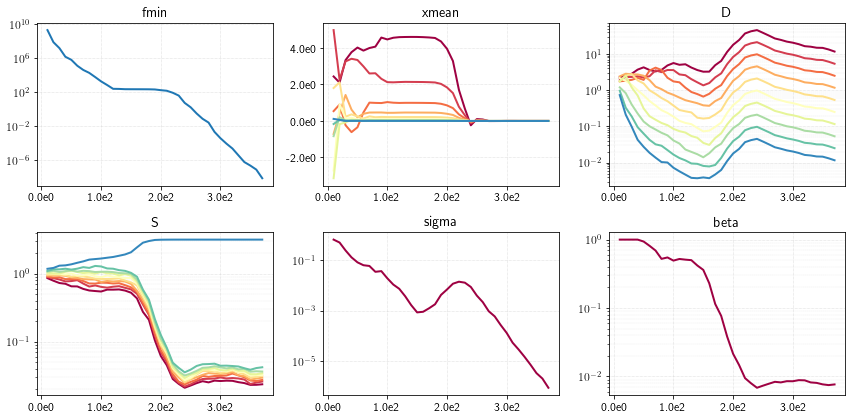

In [4]:
# 実行スクリプト
# Ellipsoid-Cigar function
N = 10

def ellcig(x):
    cig = np.ones(x.shape[1]) / np.sqrt(x.shape[1])
    d = np.logspace(0, 3, base=10, num=x.shape[1], endpoint=True)
    y = x * d
    f = 1e4 * np.sum(y ** 2, axis=1) + (1. - 1e4) * np.dot(y, cig)**2
    return f

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return ellcig(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2.)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')


## テスト関数の紹介
上のコードを実行した結果得られる最適化結果は，$d = 10$のEllipsoid-Cigar関数と呼ばれる関数
$$f(x) = 10^4 \sum_{i=1}^{d} \left(10^{3\frac{i-1}{d-1}} x_i\right)^2 + \frac{1 - 10^4}{d} \left(\sum_{i=1}^{d} 10^{3\frac{i-1}{d-1}} x_i\right)^2$$
を最適化した結果となります．この関数は凸二次関数ですが，変数毎に目的関数に与える影響が異なる（$10^{3\frac{i-1}{d-1}}$がかかっていることからわかります）ことに加え，$v = (1 / \sqrt{d}, \dots, 1 / \sqrt{d})$方向に対して目的関数が他の方向よりも鈍感である（第二項の影響です）といった特徴を持ちます．なお，この関数のヘッセ行列は
$$\nabla^2 f = 2 D_{\text{ell}} (10^4 I + (1 - 10^4) vv^T) D_{\text{ell}}$$
となります．ここで，$D_{\text{ell}} = \text{diag}(1, \dots, 10^{3\frac{i-1}{d-1}}, \dots, 10^{3})$です．また，その逆行列は
$$(\nabla^2 f)^{-1} = \frac{1}{2} D_{\text{ell}}^{-1} (10^{-4} I + vv^T) D_{\text{ell}}^{-1}$$
となります．



## DD-CMA-ESのアルゴリズムの紹介
DD-CMA-ESでは，多変量正規分布から複数の解を生成し，これらの目的関数を（多くの場合並列に）評価し，解のランキングを用いて多変量正規分布のパラメータを更新していきます．これを繰り返すことで，多変量正規分布を目的関数値の小さな（最小化を想定）領域へと収束させていきます．

DD-CMA-ESでは，多変量正規分布を$\mathcal{N}(m, \sigma^2 D C D)$ と表現します．ここで，$m \in \mathbb{R}^d$ は多変量正規分布の平均ベクトルを表し，プログラムやプロットにおいては xmean と書かれています．図のxmeanでは，$m$の各要素のイテレーション毎の変化がプロットされています．共分散行列は全体のスケーリングを表すステップサイズ $\sigma > 0$，要素毎のスケーリングを表す行列$D$（$d$次元対角行列），要素毎の相関を表す相関行列$C$の３つのパラメータを用いて表現されます．図のsigmaとDは$\sigma$と$D$の各要素を表しています．また，図中のSは相関行列$C$の$d$個の固有値の平方根の推移を表しています．



## 結果の読み取り方

複数の線がある xmean や D のプロットでは，赤系統がインデックスの小さな要素，青系統がインデックスの大きな要素に対応しています．S のプロットでは，固有値の平方根が昇順にソートされているので，カラーと要素のインデックスの間に関係はありません．

まず見るべきは，fmin です．これは，毎イテレーション生成されている解候補の中で，最小の目的関数値を表しています．最終的に望ましい解が得られているならば，実用上はそれ以上に議論する必要はないかもしれません．今回の問題では最適解の目的関数値は0であり，得られている解の目的関数値が指数的に減少している傾向が確認できます．

続いて，sigma を確認します．こちらも指数的に小さくなっていることがわかります．探索終了時点において，$\sigma^{(t)}/\sigma^{(0)} \approx 10^{-6}$程度になっていることから，初期の広がり$\sigma^{(0)}$と比較して十分に小さな分布になっていることがわかります．目的関数値が望ましい値なのかどうか以前に，正しく何らかの点に収束しているのかを見極めるためには，fmin でなく sigma を見ることが重要です．fmin が何らかの値で停滞しているように見える場合，収束しているのか，それとも探索が何らかの理由で進まなくなっているのかを fmin だけから見極めることは困難であるためです．例えば上の結果において，100〜200イテレーションの範囲において，目的関数値が停滞しているように見える箇所があります．目的関数値だけを見ていると，ここまでで収束したと見なしてしまうかもしれませんが，sigmaやSを見ると，共分散行列を適応している最中であることがわかります．

対角行列 D について注目すべきは，要素毎の比です．値が大きいということは，それだけその要素の方向に大きな標準偏差を多変量正規分布が持っていることになります．多変量正規分布がその方向に大きな広がりを持っているということは，目的関数が相対的にその方向への変化に対して鈍感であることを意味します．要素毎の目的関数値に与える感度が D によって学習されている様子が見て取れます．この結果から，この問題はインデックスの小さな変数が目的関数に与える影響は，インデックスの大きな変数が目的関数に与える影響よりも小さく，等高線を描いたとすれば各軸の長さの比が D の要素に比例した形になっているであろうことが予想されます．

最後に相関行列 C の固有値の平方根 S を確認します．イテレーション数が$2 \cdot 10^2$を超えたあたりから，S の最大の要素がその他の要素よりも$10^2$程度大きな値になっていることが見て取れます．これは，要素毎の感度をDが吸収したとしても，要素毎ではない何らかの１方向に対して目的関数に与える影響が鈍感な方向が存在していることがわかります．今回のテスト問題の場合，この方向は $v$ に対応しています．図からは読み取れませんが，以下のコードを実行すると，S の最大値に対応している固有ベクトルを確認することができます．

In [5]:
ddcma.B[:, -1]  
# B は S の各要素に対応する C の単位固有ベクトル．
# S は昇順にソートされているので，最大値に対応する固有ベクトルは B の最後の列

array([0.31620213, 0.31622076, 0.31621923, 0.31622524, 0.3162591 ,
       0.31623685, 0.31621895, 0.3162713 , 0.31620967, 0.31621442])


経験的には，$D C D$は目的関数のヘッセ行列の逆行列$\nabla^2 f$に比例するような振る舞いが見られます．実際，今回の結果でも，$D$は$D_{\text{ell}}^{-1}$に概ね比例しており，$C$は$10^{-4} I + vv^T$に概ね比例していることが，上の実験結果からも確認されます．

#### まとめ：結果の図から分かること
- 十分に収束しているのか（sigma）
- 目的関数に対する感度が変数毎にどの程度異なるのか（D）
  - 感度が大きく異なる場合（例えばDの最大値と最小値の比が10以上），悪スケールな関数と呼ばれる
  - D の要素間の比が非常に大きい（例えば$10^6$以上）場合，数値的な誤差が大きくなる恐れがあるので，変数のスケールを調整しておく必要がある．
  - D の要素間の比が発散していくような場合，定式化時に注意が必要（後述）
- 変数間の依存関係が強いのか（S）
  - S の要素間の比が非常に大きい（例えば$10^6$以上）場合，数値的な誤差が大きくなる恐れがあるので，変数のスケールを調整しておく必要がある．
  - S の要素間の比が発散していくような場合，定式化時に注意が必要（後述）

# 最適化実行前に検討すべき項目
最適化実行前に検討しておくべきこととしては，以下の３点が挙げられます
1. 目的関数評価回数 & 次元数
2. 初期分布パラメータ
3. ハイパーパラメータ（集団サイズ$\lambda$）
3. リスタート & 終了条件

## 1. 目的関数評価回数 & 次元数（CMA-ESを使うべきか）

まず，アルゴリズムの選択が不適切でないかを考えることが必要です．例えば，以下のような状況の場合には，CMA-ESよりも適切な方法があると考えられます．

- 次元数が高々５次元程度の場合：この場合，経験的にNelder-Mead法などの方が効率的であることが多く見られます．

- 許容できる実行時間内において，目的関数の評価回数が次元数の数十倍に満たない場合：この場合，CMA-ESは収束とみなせる程に分布が小さくなる前に終了してしまい，精度の高い解が得られない可能性が高いです．その場合，次元数が低い場合にはベイズ最適化のような最適化法を採用するか，さもなくばNelder-Mead法やその他の局所探索法，場合によってはベイズ最適化を採用したほうが現実的な時間内により望ましい解が得られる可能性が高いように思います．CMA-ESの場合，各イテレーションで生成される解候補は並列に評価することが可能なので，並列評価が可能なのであれば，これを考慮して最大評価回数を計算しましょう．

## 2. 初期分布パラメータ

初期分布のパラメータ $m^{(0)}$，$\sigma^{(0)}$, $D^{(0)}$, $C^{(0)}$ は，目的関数が複数の局所解を有する場合には重要な検討項目となります．ただし，予め変数毎のスケーリングなどを知らない限り$D^{(0)} = I$とし，変数間の依存関係などを知らない限り$C^{(0)} = I$とすることが自然です．以下，$m^{(0)}$と$\sigma^{(0)}$ について議論します．

- 有望な解の候補を知っている場合：例えば，既存の設計などの既存の解 $x_{\text{guess}}$ を持っている場合には，この解の周辺に初期化することが望ましいでしょう．これにより，少なくともこの初期解よりも優れた解の発見が期待できます．例えば，$m^{(0)} = x_{\text{guess}}$とし，$\sigma^{(0)}$を十分に小さな値とすれば，これを実現できます．ここで，$\sigma^{(0)}$は，対象としている問題毎に異なるでしょう．例えば，解の各要素が$10^{-4}$程度変化しただけではほとんど目的関数に影響しないであろう，などといった既存知識があるのであれば，$\sigma^{(0)} = 10^{-4}$などとすれば良いでしょう．変数毎にこの値が変わるようであれば，$\sigma^{(0)} = 1$とし，代わりに$D^{(0)}$の要素を変数毎に上と同様の方法で決定すれば良いでしょう．CMA-ESでは，分布の広がりが小さすぎる場合（すなわち大きく移動すれば目的関数を改善できるのに，広がりが狭すぎで移動できない場合），比較的高速に$\sigma$を大きくすることが可能なので，局所的な探索をしたい場合には，十分に小さな$\sigma^{(0)}$で初期化しておけば良いでしょう．

- 各設計変数の定義域が有限な場合 or 各設計変数の合理的な値の範囲を知っている場合：この場合，各設計変数の範囲$[L, U]$の中で，ランダムに初期化することが望ましいでしょう．例えば，$m^{(0)}_i \sim \mathcal{U}[L_i, U_i]$などと区間内の一様分布に従ってサンプリングし，$\sigma^{(0)} = 1$，$D^{(0)}_i = \frac{U_i - L_i}{4}$ などと初期化する方法が考えられます．ただし，$\sigma^{(0)}$については，より小さな値で初期化したほうがいい場合もあります．$\sigma^{(0)}$が大きいほど，特定の局所解に収束しがちになります．これが望ましい局所解であればよいのですが，そうでない場合，小さな$\sigma^{(0)}$としたほうが，多様な局所解を探索できる場合があります．

実際には，一度しか探索できないという場面は少ないでしょうから，有望な解の候補を知っている場合には，まずはその解を$m^{(0)}$，$\sigma^{(0)}$を適切に定めて探索し，その後$\sigma^{(0)}$を$10$倍して探索，$100$倍して探索，などと，徐々に大域的な探索を実行していくことが良いかと思います．なお，$\sigma^{(0)}$が大きくなるほど，$m^{(0)}$への依存性は下がっていきます．

### 2.1 10次元Rosenbrock 関数での例
Rosenbrock関数は
$$f(x) = \sum_{i=1}^{d-1} 100  \left(x_i^2 - x_{i+1}\right)^2 + \left( x_i - 1 \right)^2$$
と定義される四次関数です．最適解は$x^* = (1, \dots, 1)$となりますが，$(0, \dots, 0)$と$(1, \dots, 1)$をつなぐ曲線の周辺のみが低い目的関数値を取り，それ以外が相対的に高い目的関数値を取るような関数です．広い範囲を探索した場合，どこから探索してもまず原点付近に正規分布が一度集まるような傾向が見られます．

#### 確認事項
- 原点に平均ベクトルを初期化した場合，mode 1 ($\sigma^{(0)} = 10^{-1}$)とmode 2 ($\sigma^{(0)} = 10^{-4}$)を比較することで，初期ステップサイズが小さすぎる場合には高速にこれを大きくできることを確認．
- 最適解周辺に平均ベクトルを初期化した場合，mode 3 ($\sigma^{(0)} = 10^{-1}$)とmode 4 ($\sigma^{(0)} = 1$)を比較することで，初期ステップサイズが十分に小さくないと局所探索にならない（良い解からスタートすることの意味があまりない）ことを確認．

10 100 425.59177338535994 260.5164397606097
20 200 96.9429044407606 96.9429044407606
30 300 80.16444403954415 73.93364226362922
40 400 72.02106368171006 72.02106368171006
50 500 70.91943750039334 70.91943750039334
60 600 69.72467635827736 69.72467635827736
70 700 67.85113568756363 67.85113568756363
80 800 52.721962374547815 52.721962374547815
90 900 31.6979127338896 18.70904635431791
100 1000 12.040213036253201 11.957062969331893
110 1100 1.8017224891401635 1.8017224891401635
120 1200 0.5210488285101424 0.5210488285101424
130 1300 0.3959610852745926 0.3232584998850991
140 1400 0.14275276376480794 0.11456604068023325
150 1500 0.09804924579882882 0.09752801961873866
160 1600 0.08373647930241346 0.08373647930241346
170 1700 0.06530912832706377 0.06530912832706377
180 1800 0.038686194827930204 0.038686194827930204
190 1900 0.01925078400255991 0.01563862322121233
200 2000 0.0064437054459588645 0.005246393223958596
210 2100 0.004216508858893141 0.0036762830727343748
220 2200 0.00068740575482

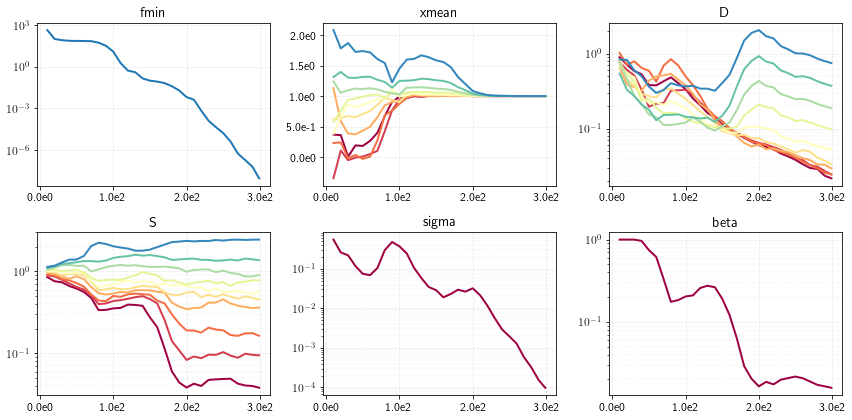

In [6]:
# 実行スクリプト
# Rosenbrock function
N = 10

def rosenbrock(x):
    a = 1e2                
    return a * np.sum(
        (x[:, :-1]**2 - x[:, 1:])**2, axis=1) + np.sum(
            (x[:, :-1] - 1.0)**2, axis=1)

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rosenbrock(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# 初期mと初期D （D0 の係数 1e-1 と 1e-4 を比較）
mode = 3
if mode == 0:
    # 原点に初期化
    xmean0 = np.zeros(N)
    D0 = 1e-1 * np.ones(N)
elif mode == 1:
    # 原点に初期化（初期ステップサイズがかなり小さい場合）
    xmean0 = np.zeros(N)
    D0 = 1e-4 * np.ones(N)
elif mode == 2:
    # 最適解周りに初期化
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1e-1 * np.ones(N)
elif mode == 3:
    # 最適解周りに初期化（初期ステップサイズが大きい場合）
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1e0 * np.ones(N)

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

### 2.1 10次元Rastrigin 関数での例
Rastrigin関数は
$$f(x) = \sum_{i=1}^{d} x_i^2 + 10 ( 1 - \cos(2 \pi x_i))$$
と定義される多峰性関数（局所解を複数持つ関数）です．最適解は$x^* = (0, \dots, 0)$となりますが，各座標の値が整数の値付近において，局所解が存在します．ただし，巨視的に見ると下凸のような景観をしています．

#### 確認事項
- $m^{(0)}$を$(1, \dots, 1)$付近に初期化した場合，初期ステップサイズが十分に小さければ（ここでは$\sigma^{(0)} = 0.1$），局所的に目的関数値が改善されること．
- ただし，あくまで局所的にしか改善されないため，比較的大きな$\sigma^{(0)}$のほうが良い局所解へと収束する場合があること．当然，悪くなる場合もあること．

10 100 70.23730527729593 65.85818507328338
20 200 90.93957835364688 65.85818507328338
30 300 58.17713010340192 44.733783636895645
40 400 65.51821248437585 44.733783636895645
50 500 46.242299170275835 44.733783636895645
60 600 48.63040535978327 44.505435387912186
70 700 17.989754654623738 16.445740304741634
80 800 15.341187065569272 14.881046850567266
90 900 12.531628747077933 12.531628747077933
100 1000 12.172109815816036 12.155358830483475
110 1100 11.976691927607616 11.975806335876925
120 1200 11.949321047501861 11.947687447315893
130 1300 11.941184425823984 11.941184425823984
140 1400 11.940199115036569 11.940002135175709
150 1500 11.939599296642236 11.939559587318975
160 1600 11.939526910434871 11.939524027053654
170 1700 11.939502931119451 11.939502621249101
180 1800 11.939499217274246 11.939499057417247
190 1900 11.939498749738508 11.939498727781954
200 2000 11.939498635697385 11.939498631083993
210 2100 11.939498616224421 11.939498616224421
220 2200 11.939498609887693 11.9394986

<ipython-input-3-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


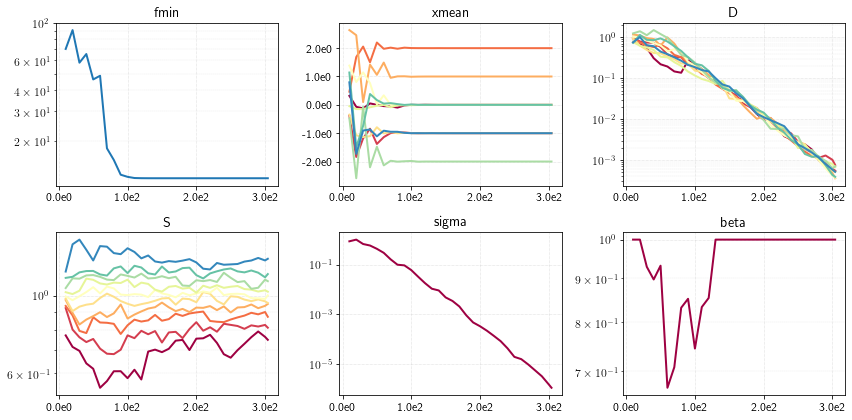

In [7]:
# 実行スクリプト
# Rosenbrock function
N = 10

def rastrigin(x):
    a = 1e1                
    return np.sum(x[:, :]**2 + a * (1.0 - np.cos(2.0 * np.pi * x[:, :])), axis=1) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rastrigin(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# 初期mと初期D （D0 の係数 1e-1 と 1e-4 を比較）
mode = 1
if mode == 0:
    # ステップサイズが小さい場合
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1e-1 * np.ones(N)
elif mode == 1:
    # ステップサイズが相対的に大きい場合
    xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
    D0 = 1.0 * np.ones(N)

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

## 3. ハイパーパラメータ（集団サイズ$\lambda$）

CMA-ESのハイパーパラメータ全てに対して，最適化問題の次元数から求まる推奨値が設計されています．ただし，集団サイズ$\lambda$については，大きな値を与えることが望ましい場合があります．なお，$\lambda$を大きくすると，自動的に学習率などのパラメータの推奨値も変化します．

1. 目的関数の評価を，デフォルトの$\lambda$ ($= 4 + \lfloor 3 \log(d) \rfloor$)よりも多く並列計算可能である場合．一般に，$\lambda \leq d$ 程度までは，$\lambda$を大きくすれば，探索に必要なイテレーション数は少なくなるため，探索終了までの実時間を削減することが可能です．
2. 目的関数が多峰性関数である場合．集団サイズを大きくすることでより目的関数値の小さな局所解を得られる場合が多くあります．

### 3.1 並列化のために集団サイズを増加させる効果の確認
10次元 Ellipsoid-Cigar 関数を用いて，デフォルトの集団サイズの場合（$\lambda = 10$，一番上の図）と大きな集団サイズ$\lambda = 20, 40, 80, \dots$の場合のイテレーション数を比較します．位置イテレーションに必要な評価を全て並列計算できる場合，実行時間はイテレーション数に概ね依存します．

10 100 745344219.9311187 745344219.9311187
20 200 304693201.08508474 266531193.14556867
30 300 172322786.5040201 133654849.26416665
40 400 19005252.83561328 15650468.930018649
50 500 3362216.372287475 1815779.859097136
60 600 871262.4839055791 411185.01252716593
70 700 81559.74514566024 81559.74514566024
80 800 38965.45169581019 37791.77536268183
90 900 15112.904468555585 15112.904468555585
100 1000 4073.864418552257 4073.864418552257
110 1100 740.5698805570719 621.2833603057661
120 1200 392.1085565104149 326.61764441931155
130 1300 156.92163381027058 102.10909287026152
140 1400 75.51525531156221 75.51525531156221
150 1500 56.529361133638304 56.529361133638304
160 1600 52.85390213271603 52.085003616055474
170 1700 51.36723718093708 51.36723718093708
180 1800 50.88321612623986 50.88321612623986
190 1900 50.02624174626544 50.02624174626544
200 2000 46.703917455568444 46.703917455568444
210 2100 40.90360199724091 38.37420761754038
220 2200 32.64581742041628 32.64581742041628
230 2300 19.7

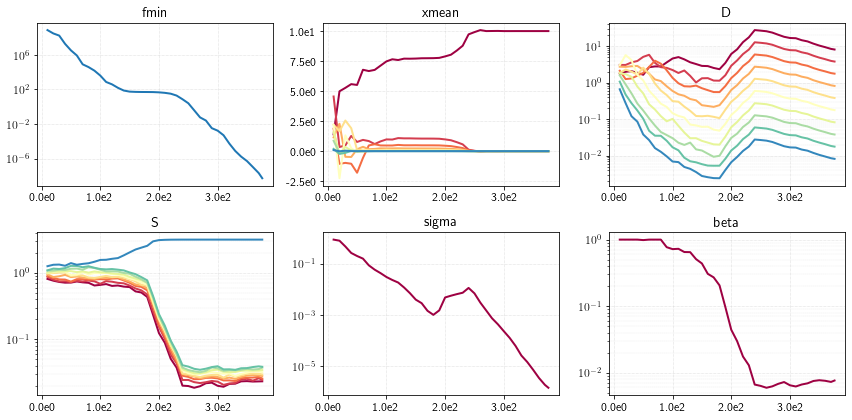

In [8]:
# 実行スクリプト
lam = 10

# Ellipsoid-Cigar function
N = 10

def ellcig(x):
    cig = np.ones(x.shape[1]) / np.sqrt(x.shape[1])
    d = np.logspace(0, 3, base=10, num=x.shape[1], endpoint=True)
    y = x * d
    f = 1e4 * np.sum(y ** 2, axis=1) + (1. - 1e4) * np.dot(y, cig)**2
    return f

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return ellcig(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=lam)  # 変更点はここ
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

集団サイズを大きくした場合に必要なイテレーション数が減少するのは，分布パラメータの更新に用いる学習率を大きく設定できる（推奨値もそのように設定されている）ためです．また，学習率の推奨値の設定から，$\lambda = 4d^2$程度まではイテレーション数を削減できますが，それ以上ではイテレーション数は削減されません．

### 3.2 多峰性関数における集団サイズを増加させる効果の確認

上述のRastrigin関数のように，大域的に見れば下凸になっているようにみえる多峰性関数を大域的単峰な関数，もしくは大谷構造をもつ関数，などと呼びます．このような関数の場合，
- 初期ステップサイズを大きめに設定
- 集団サイズを大きめに設定
することで，目的関数値の低い局所解を獲得できる可能性があります．

10 100 98.27768192598413 92.87006227437121
20 200 91.43708193707974 81.05008383006466
30 300 87.18606450726166 63.39429703995008
40 400 89.75560061833431 57.21363050058744
50 500 72.58093245049379 57.21363050058744
60 600 73.10540090699482 57.21363050058744
70 700 42.96443737498035 42.09510956408468
80 800 53.34152152141468 37.42948505826688
90 900 30.90177664155873 26.205588851619922
100 1000 21.700202880478205 20.3087473663089
110 1100 17.125987129059236 17.125987129059236
120 1200 16.2642450655289 16.2642450655289
130 1300 16.078670636317582 16.078670636317582
140 1400 15.984502961693204 15.95872038785512
150 1500 15.927270043756224 15.927270043756224
160 1600 15.920106141444109 15.920106141444109
170 1700 15.919546053524812 15.919490174779696
180 1800 15.919414436084713 15.91940187289222
190 1900 15.919359539468056 15.919357073961335
200 2000 15.91933511487236 15.91933511487236
210 2100 15.919330685719462 15.919330685719462
220 2200 15.919330235741295 15.919330212731186
230 2300 15

<ipython-input-3-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


320 3200 15.919329800035444 15.919329800035438
330 3300 15.919329800035431 15.919329800035431
Terminated with condition: bbob_tolhistfun
Restart with popsize: 20


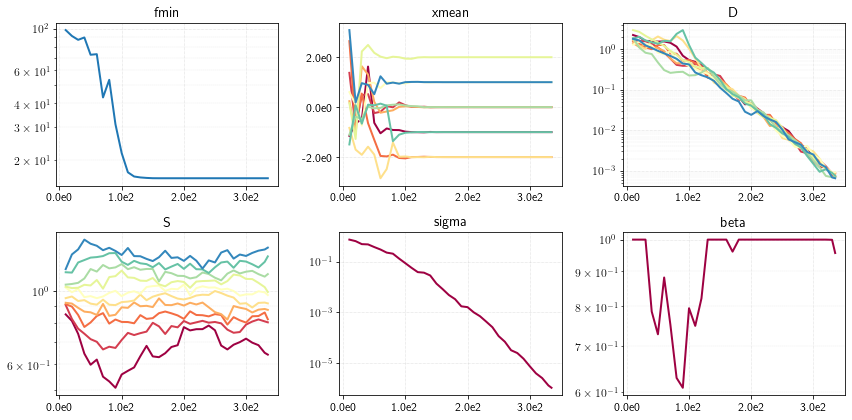

In [9]:
# 実行スクリプト
N = 10
xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
mode = 2
if mode == 0:
    lam = 200
    D0 = 2 * np.ones(N)
elif mode == 1:
    lam = 200
    D0 = 0.1 * np.ones(N)
elif mode == 2:
    lam = 10
    D0 = 2 * np.ones(N)
else:
    lam = 10
    D0 = 0.1 * np.ones(N) 


def rastrigin(x):
    a = 1e1                
    return np.sum(x[:, :]**2 + a * (1.0 - np.cos(2.0 * np.pi * x[:, :])), axis=1) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rastrigin(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=lam)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

一方で，例外も存在します．例えば，Double-Sphere関数（$s > 0$）
$$
f(x) = \min\left[ \sum_{i=1}^{d} (x_i - a_i)^2, d + s \sum_{i=1}^{d} (x_i - b_i)^2\right]
$$
がこれに該当します．この関数は二つの局所解しか持ちません．最適解は$a$で目的関数値が$f(a) = 0$，もう一つの局所解が$b$で目的関数値が$f(b) = d$となります．Rastrigin関数と異なり，大域的にみても二つの関数に分かれてしまっていることがわかります．また，$s$が小さい場合，局所解を形成する方の目的関数値のほうが小さい領域が広く存在しています．このような関数の場合，ステップサイズを大きくして大域的な探索を試みると，局所解の谷しか見えず（大域的最適解を形成する関数の領域に解が生成される確率が低い），局所解に収束する現象が見られます．このような関数を大域的多峰な関数であったり，UV構造を持つ関数などといいます．

#### 確認項目
Double Sphere関数の場合
- 初期ステップサイズを大きめに設定
- 集団サイズを大きめに設定
がいずれも逆効果になること

10 2000 10.179179944050835 10.179179944050835
20 4000 10.000182034299774 10.000182034299774
30 6000 10.0000005030604 10.0000005030604
40 8000 10.000000000673712 10.000000000673712
50 10000 10.00000000000019 10.00000000000019
60 12000 10.0 10.0
Terminated with condition: bbob_tolhistfun
Restart with popsize: 400


<ipython-input-3-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


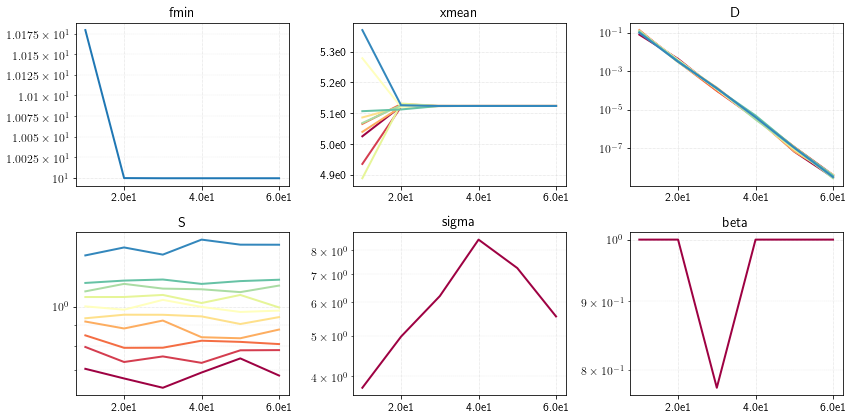

In [10]:
# 実行スクリプト
N = 10
xmean0 = np.zeros(N)
mode = 0
if mode == 0:
    lam = 200
    D0 = 2 * np.ones(N)
elif mode == 1:
    lam = 200
    D0 = 0.1 * np.ones(N)
elif mode == 2:
    lam = 10
    D0 = 2 * np.ones(N)
else:
    lam = 10
    D0 = 0.1 * np.ones(N) 


def doublesphere(x):
    s = 0.2
    a = 2.5
    b = np.sqrt((a**2 - 1) / s)
    f1 = np.sum((x[:, :] - a)**2, axis=1)
    f2 = N + s * np.sum((x[:, :] - b)**2, axis=1)
    return np.fmin(f1, f2)

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = - np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return doublesphere(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=lam)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

## 4. リスタート & 終了条件

一度の探索で望ましい解が得られる可能性は現実的にはかなり低いでしょう．その場合，繰り返し探索を行うことが必須となります．その際，前項目で見たように，集団サイズや初期分布パラメータを変えながらリスタートすることが望ましいです．そのようなリスタート戦略は，IPOPメカニズム，BIPOPメカニズムなどとして，提案されています．今回のコードでは，IPOPメカニズム（リスタート毎に集団サイズを倍にする方法）が実装されています．

リスタート戦略を用いる際，利用者が検討すべき項目は，各リスタートの終了条件です．終了条件が適切でないと，探索が終わっていないのに打ち切ってしまう，もしくはいつまでもリスタートがかからない，といった問題があります．

上のコードでは，
- 分布が小さくなったら終了
- 共分散行列の条件数が大きくなりすぎたら終了
- 目的関数値が一定イテレーション以上改善されなければ終了
- ある目的関数値に到達したら終了（この場合，リスタートもかけない）
- 最大の目的関数評価回数に達したら終了（この場合，リスタートもかけない）
などの終了条件が実装されています．分布の大きさや条件数に関する終了条件のしきい値は，計算誤差を考慮して予め設定されていますが，実際に解いている問題によっては，ある程度以上変数が変化しない限りほとんど目的関数に差は無いから無視して良い，もしくはある程度以上の精度で解を社会実装できないから，それ以上の精度はそもそも必要ない，などといった事前情報がある場合があるでしょう．その場合には，しきい値を事前情報によって調整することで，効率的な探索が可能になる可能性があります．

10 100 13.652726221295625 13.652726221295625
20 200 11.402128947358204 11.157024327886425
30 300 10.01680555246055 10.01680555246055
40 400 9.959706710102047 9.956870972484337
50 500 9.951228629312153 9.951228629312153
60 600 9.949754828794136 9.949754828794136
70 700 9.949630107343522 9.949630107343522
80 800 9.949593687501583 9.949593687501583
90 900 9.949591655884147 9.949591655884147
100 1000 9.949590855834677 9.949590840293203
110 1100 9.949590618163233 9.949590596949943
120 1200 9.949590578044079 9.949590578044079
130 1300 9.949590571766498 9.949590571766498
140 1400 9.949590571233674 9.949590571105986
150 1500 9.949590571002682 9.949590570996346
160 1600 9.949590570938764 9.949590570938764
170 1700 9.949590570934017 9.949590570933868
180 1800 9.949590570933125 9.949590570933001
190 1900 9.949590570932937 9.949590570932937


<ipython-input-3-ef6e8ced20ae>:243: RuntimeWarning: assumed no tie, but there exists
  warnings.warn("assumed no tie, but there exists", RuntimeWarning)


200 2000 9.949590570932923 9.949590570932921
210 2100 9.949590570932918 9.949590570932916
Terminated with condition: bbob_tolhistfun
Restart with popsize: 20
10 200 93.20326470888733 71.14150098864238
20 400 81.85619222838888 65.63993575087972
30 600 84.2223061254529 53.74044156020991
40 800 50.54404665035322 50.54404665035322
50 1000 32.9480704591682 24.1842818044198
60 1200 13.792520970039481 13.792520970039481
70 1400 7.441686368991364 7.319910662293161
80 1600 6.142211305753939 6.142211305753939
90 1800 5.981790192248175 5.980420593796131
100 2000 5.970866980385405 5.970560190542794
110 2200 5.969825269584602 5.969825269584602
120 2400 5.9697601552322865 5.969759975988376
130 2600 5.969754755411541 5.969754755411541
140 2800 5.969754372884741 5.969754372884741
150 3000 5.969754344824994 5.969754344824994
160 3200 5.969754342814623 5.96975434278683
170 3400 5.969754342593191 5.969754342593191
180 3600 5.969754342563389 5.969754342563389
190 3800 5.969754342560142 5.969754342560128
2

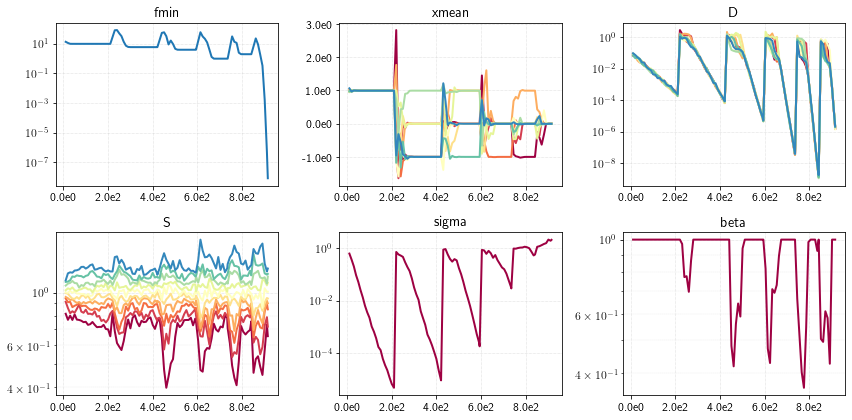

In [11]:
# 実行スクリプト
N = 10
xmean0 = np.ones(N) + np.random.randn(N) * 1e-1
D0 = 0.1 * np.ones(N)

def rastrigin(x):
    a = 1e1                
    return np.sum(x[:, :]**2 + a * (1.0 - np.cos(2.0 * np.pi * x[:, :])), axis=1) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return rastrigin(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size 
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

# 定式化の見直し

最適化を実行してみたが望ましい解が得られない，という場面は多々あると思います．まず前項目までにみた検討項目について，十分な回数のリスタートがなされているのか，適切な終了条件が設定されているのか，初期分布パラメータは適切か，など，再度確認してみましょう．それでもうまく行かない場合，最適化問題の定式化を再検討することが必要になります．その際，分布パラメータの推移（上で出力しているような図）も確認しましょう．その中に，うまく解くためのヒントが隠されている場合があります．

ここでは，実際に起こりがちな，CMA-ESにとって解きにくい目的関数の設計と，そのときのCMA-ESの振る舞いをいくつか紹介します．

1. ほとんど平らな多峰性の目的関数 or 周期関数
2. 目的関数に影響を与えない変数
3. 尖った等高線を持つ目的関数

## 1. ほとんど平らな多峰性の目的関数 or 周期関数

CMA-ESは目的関数の値を直接用いず，複数の解のランキングに基づいて探索をしていきます．そのため，どれだけ勾配が小さくても，解の優越が正しく決定できる限り，勾配の小さな問題でも全く問題なく最適化ができます．例えば，
$$
f(x) = \sum_{i=1}^{d} x_i^2
$$
と
$$
f(x) = 20 - 20 \exp\left(-0.2 \sqrt{\frac{1}{d}\sum_{i=1}^{d} x_i^2}\right)
$$
は，単調増加変換の関係にあるため，CMA-ESからは等価な関数であるように扱われます．これは，目的関数のスケーリングを考慮しなくて良い，という観点で望ましい性質の一つです．

ただし，ここに多峰性が含まれると，注意すべき状況が発生します．例えば，上の関数に周期関数を加えた Ackley関数
$$
f(x) = 20 - 20 \exp\left(-0.2 \sqrt{\frac{1}{d}\sum_{i=1}^{d} x_i^2}\right) + \exp(1) - \exp\left(\frac{1}{d}\sum_{i=1}^{d} \cos(2\pi x_i)\right)
$$
を考えましょう．局所解は複数存在しますが，探索領域が$[-30, 30]^d$程度に制限されている場合，この関数はCMA-ESにとって，最適解$x^* = 0$を比較的容易に発見できる関数です．しかし，その探索領域が制限されていない場合，$[-30, 30]^d$の外側では追加された項$\exp(1) - \exp\left(\frac{1}{d}\sum_{i=1}^{d} \cos(2\pi x_i)\right)$が支配的になります．この場合，CMA-ESからみれば，ほとんど周期関数を複数の周期に渡って最適化しているように見えます．周期関数を複数周期に渡って探索しようとした場合，挙動が不安定になる場合があります．

#### 確認事項
以下，Ackley関数を，と，探索領域を設けて最適化した場合の比較です．
- 探索領域を設けずに最適化した場合（初期ステップサイズを30と比較的大きめに設定），$\sigma  D$ の値が以上に大きな値となり，収束できないか非常に効率が悪いこと
- 制約条件を設けることで，不安定な振る舞いを回避できること



10 100 20.50821465947673 16.99071761485128
20 200 17.26384788946904 16.547316215221915
30 300 12.523500689760041 12.523500689760041
40 400 11.334305749231618 11.334305749231618
50 500 7.270023762718277 6.771563561865921
60 600 3.7941737692766386 3.7941737692766386
70 700 3.0158134868728013 2.881031188126439
80 800 2.544161304677587 1.786187396326217
90 900 1.082441018104324 1.082441018104324
100 1000 0.22297087186150444 0.22297087186150444
110 1100 0.10702718193358551 0.10702718193358551
120 1200 0.05249741752117432 0.038351265151692626
130 1300 0.020286400075494093 0.020286400075494093
140 1400 0.006959964608691749 0.00637702647703442
150 1500 0.0027281016746010245 0.0027281016746010245
160 1600 0.0015672276642728633 0.0015191063924806514
170 1700 0.0006051597855130098 0.000398885819144823
180 1800 0.0002815328306420284 0.00023985948009608293
190 1900 0.00011782541989902029 0.00011481061931517544
200 2000 5.180266430171443e-05 4.0011913542858935e-05
210 2100 2.4600974234179063e-05 2.4

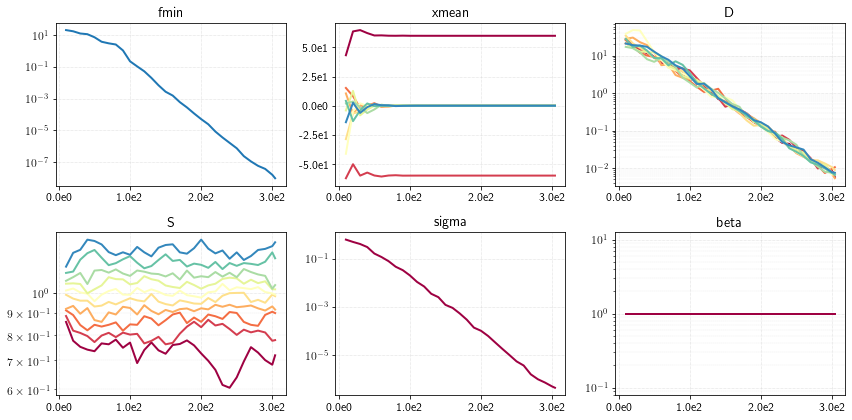

In [12]:
# 実行スクリプト
# Ellipsoid-Cigar function
N = 10
xmean0 = 30 * np.random.rand(N)  # 恣意的に最適解からずらして初期化
D0 = 30 * np.ones(N)  # 探索領域の幅の1/4
def ackley(x):
    a = 20
    b = 0.2
    c = 2 * np.pi
    f1 = a * (1 - np.exp(-b*np.sqrt(np.mean(x**2, axis=1))))
    f2 = np.exp(1) - np.exp(np.mean(np.cos(c * x), axis=1))
    return f1 + f2

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
if False:
    # 制約条件を考慮した場合
    LOWER_BOUND = -np.inf * np.ones(N)
    UPPER_BOUND = np.inf * np.ones(N)
else:
    # 制約条件を考慮しない場合
    LOWER_BOUND = -30.0 * np.ones(N)
    UPPER_BOUND = 30.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return ackley(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        xmean0 = 30 * np.random.rand(N)  # 恣意的に最適解からずらして初期化
        D0 = 15 * np.ones(N)  # 探索領域の幅の1/4
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### まとめ
- 最適解から遠く離れた領域の目的関数値が一定値に近づいていくようなケースでは，CMA-ESの振る舞いが不安定になり，探索が非効率になるか収束しないケースがあります．そのような目的関数を回避するか，合理的な設計変数の範囲が分かる場合には制約を設けましょう．
- $\sigma D$ の値が以上に大きくなっている現象が見られた場合，この問題が起こっている可能性が高いので，制約を設けるなどの工夫を試みてみると良いでしょう．

#### 補足（制約について）
制約を設けた場合に xmean が制約の外側に収束していないように見えるのは，ミラーリングという制約対処を用いており，制約の外側に仮想的な景観を作り出して探索しているためです．得られた xmean をミラーリングすると制約の内側の解が得られていることがわかります．

In [13]:
print(ddcma.xmean)
print(mirror(ddcma.xmean, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC))

[ 6.00000000e+01 -6.00000000e+01  3.40687754e-10 -2.19390706e-09
  1.42467929e-09  3.36319764e-10 -7.26902380e-11  2.61021051e-09
  4.28846613e-10  1.46593218e-10]
[ 4.73028194e-09  1.24165922e-09  3.40687478e-10 -2.19390728e-09
  1.42468082e-09  3.36321193e-10 -7.26885219e-11  2.61021071e-09
  4.28848068e-10  1.46592072e-10]


## 2. 目的関数に影響を与えない変数

目的関数に影響を与えない変数が多く含まれる場合，それらを取り除いた場合と比較して探索効率が著しく悪化する現象が見られます．
このような冗長な変数は，例えばover-parameterizedな回帰モデルの係数を最適化する場合など，しばしば現れます．

例えば，$d = 20$次元のSphere関数
$$
f(x) = \sum_{i=1}^{d} x_i^2
$$
と$d = 100$次元であるがそのうち$20$個の変数しか意味を持たないsubspace-Sphere関数
$$
f(x) = \sum_{i=1}^{\lfloor d / 5 \rfloor} x_i^2
$$
で挙動を比較してみましょう．

#### 確認事項
- 本質的には同じ目的関数であるが，冗長な変数が存在すると$\sigma$の減少速度が遅くなり，収束までにより多くの評価回数を費やすこと
- 冗長な変数が存在する場合，共分散行列の条件数が発散していくこと（その結果，数値誤差が大きくなる恐れがある）

10 170 1292.1142641381755 1096.119699523437
20 340 961.9342133158043 949.2856409277971
30 510 647.767988491407 647.767988491407
40 680 407.30077562654327 349.79231410059214
50 850 309.8748128205515 290.3506603415197
60 1020 189.21621067072377 189.21621067072377
70 1190 139.69959153022467 132.93890853166832
80 1360 83.62152259675428 83.62152259675428
90 1530 67.99226681166778 67.47491965748362
100 1700 47.5910433586507 45.45050470527044
110 1870 26.396848284297185 26.396848284297185
120 2040 20.64093792925756 20.64093792925756
130 2210 17.798500631596948 16.964073102736126
140 2380 8.386259877041867 8.386259877041867
150 2550 5.54826407992766 5.54826407992766
160 2720 5.2257551267897755 4.52409610235781
170 2890 3.578635102474375 3.4204955699753747
180 3060 2.163384892907059 2.163384892907059
190 3230 1.3783800345761412 1.3783800345761412
200 3400 1.1028100529512126 1.1028100529512126
210 3570 0.6319511009077031 0.6319511009077031
220 3740 0.6658055570490966 0.5629636600004799
230 3910 

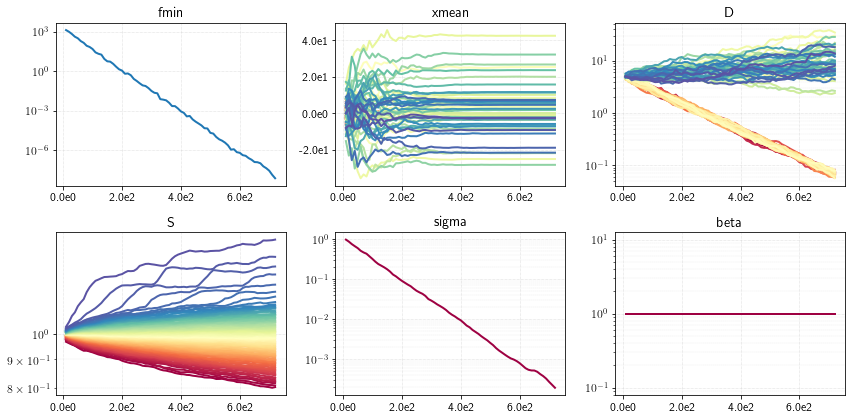

In [32]:
# 実行スクリプト
mode = 0
if mode == 0:
    # 冗長な設計変数
    N = 100
    def subspace_sphere(x):
        dd = 50
        return np.sum(x[:, :dd]**2, axis=1)
elif mode == 1:
    # 冗長な設計変数を取り除いた場合
    N = 50
    def sphere(x):
        return np.sum(x[:, :]**2, axis=1)

xmean0 = 5 * np.random.rand(N)
D0 = 5 * np.ones(N) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    if mode == 0:
        return subspace_sphere(xx)
    else:
        return sphere(xx)

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        xmean0 = 5 * np.random.rand(N)
        D0 = 5 * np.ones(N) 
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### まとめ
- 冗長な変数がある場合，
  - $\sigma$ の減少速度の低下による探索効率の低下
  - 共分散行列の条件数の発散
- 前者の問題は，冗長な変数の割合が少なければほとんど影響は現れないため，現実的な時間で最適化が進んでいれば特に気にする必要はないかもしれません
- 後者の問題は，求めたい設計変数の精度が高く精緻化が必要な場合には，条件数が発散することによる数値誤差の問題が発生し得ます．そのような場合，探索結果として得られた共分散行列を用いて，次元削減することをおすすめします．一例を以下にあげます．

In [33]:
Cov = ddcma.transform(ddcma.transform(np.eye(ddcma.N)).T)  # 共分散行列を作成
eigval, eigvec = np.linalg.eigh(Cov)  # 固有値分解，eigvec[:, i] が eigval[i] に対応する単位固有ベクトル
print('共分散行列の固有値', eigval)  # 固有値の大きさが大きいもの（冗長な次元）と小さいもの（必要な次元）に分かれていることを確認

N = np.sum(eigval < 1e-8)  # 次元削減後の次元数
xbase = np.copy(ddcma.xmean)  # 前回探索時の平均ベクトルを座標系の原点とする
basis = np.copy(eigvec[:, :N])  # 次元削減後の基底

def reconstruct(x):
    # 次元削減後の（CMA-ESが新たに探索する）設計変数からもとの変数を復元
    return xbase + np.dot(x, basis.T)

共分散行列の固有値 [1.08512054e-10 1.13646350e-10 1.21670141e-10 1.24212919e-10
 1.26896234e-10 1.28405378e-10 1.32261921e-10 1.32613549e-10
 1.35176953e-10 1.36844617e-10 1.40158727e-10 1.41833462e-10
 1.42806484e-10 1.45638673e-10 1.48722362e-10 1.49221922e-10
 1.49942284e-10 1.52413453e-10 1.54074028e-10 1.57291388e-10
 1.58539757e-10 1.61972877e-10 1.63365937e-10 1.65111617e-10
 1.68729605e-10 1.69905515e-10 1.71538877e-10 1.73673758e-10
 1.74473008e-10 1.78412324e-10 1.81522875e-10 1.83172457e-10
 1.87318680e-10 1.88161419e-10 1.90631206e-10 1.94137141e-10
 1.95449370e-10 1.98219147e-10 2.00171826e-10 2.02443160e-10
 2.04261009e-10 2.10638164e-10 2.13458511e-10 2.14994875e-10
 2.15541880e-10 2.22901116e-10 2.25004132e-10 2.32298214e-10
 2.39356412e-10 2.54139432e-10 1.97011211e-07 2.49550921e-07
 5.69646600e-07 6.60859107e-07 7.62493038e-07 9.22201981e-07
 9.88607351e-07 1.06842722e-06 1.12281656e-06 1.22094451e-06
 1.26180547e-06 1.29338757e-06 1.30804718e-06 1.32752508e-06
 1.41259786e-0

10 150 35.78716764844854 33.78225783478785
20 300 14.615021631150631 14.615021631150631
30 450 8.205193480164105 7.34978275549623
40 600 5.0558105538372065 4.798450216594334
50 750 2.5291801832318614 2.5291801832318614
60 900 1.594724757918165 1.594724757918165
70 1050 0.5796184435637763 0.5796184435637763
80 1200 0.4239788391976005 0.38872843816729635
90 1350 0.19599366864120268 0.19290219542166
100 1500 0.07832382085248497 0.07428237687214836
110 1650 0.03473112423155204 0.03473112423155204
120 1800 0.01744819404846248 0.016394094186298537
130 1950 0.006804705198703581 0.006804705198703581
140 2100 0.005078066459744821 0.005078066459744821
150 2250 0.0023710226519809 0.0023710226519809
160 2400 0.0017995777110747153 0.0017271230477638364
170 2550 0.0006031113936970591 0.0006031113936970591
180 2700 0.00034952213169316246 0.00034952213169316246
190 2850 0.00021410252960920147 0.00021410252960920147
200 3000 0.0001344067421482397 0.00012910577786467758
210 3150 8.306353694145907e-05 8.

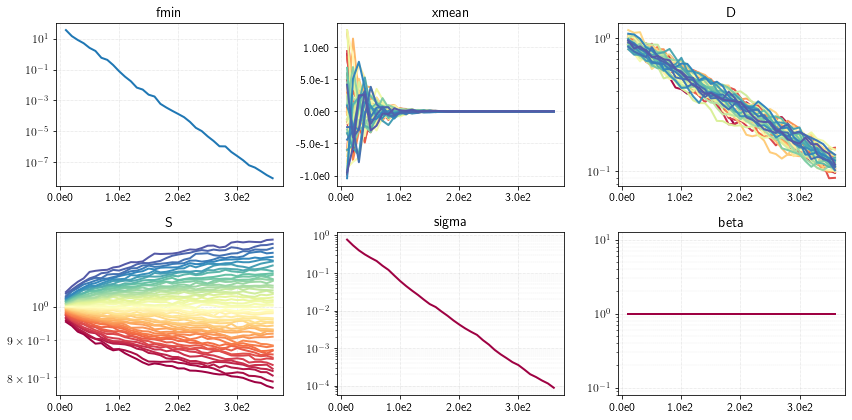

In [34]:
# 実行スクリプト
xmean0 = np.zeros(N)  # 原点が前回探索した解なので，その周辺から始めることがおすすめ
D0 = np.ones(N) 

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -np.inf * np.ones(N)
UPPER_BOUND = np.inf * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return subspace_sphere(reconstruct(xx))  # CMA-ESが探索する空間は次元削減後の空間なので，目的関数にわたすときには reconstruct 

# Setting for resart
NUM_RESTART = 1  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=xmean0, sigma0=D0)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        xmean0 = 5 * np.random.rand(N)
        D0 = 5 * np.ones(N) 
        ddcma = DdCma(xmean0=xmean0, sigma0=D0, lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')


## 3. 尖った等高線を持つ目的関数

CMA-ESは勾配を利用せず，また目的関数の値も直接は使用しないため，微分可能かどうかが直接は探索のしやすさに影響しません．例えば，なめらかな関数を単調増加変換した関数はなめらかになる保証はなく，勾配も定義されない可能性がありませんが，CMA-ESにとってはなめらかな関数と同等に扱われます．なめらかな関数の単調変換で表されるような関数は，等高線がなめらかになります．

一方，等高線が尖った目的関数の場合には，注意が必要です．
例えば，
$$
f(x) = \sum_{i=1}^{d} |x_i|
$$
という関数は，$x_i = 0$となる任意の点において，等高線が尖っていることが容易にわかります．これを一般化したものとして，
$$
f(x) = \left(\sum_{i=1}^{d} |x_i|^{p}\right)^{1/p}
$$
なども考えられます．$p$が小さい値になると，より尖った等高線となります．

等高線が尖っていても，その角度が0でなければ（例えば$p = 1$のケース），うまく探索できるでしょう．しかし，その角度が0になるケースでは，失敗する場合があります．

#### 確認事項
- $p = 1/4$のとき，デフォルトの集団サイズでは最適解でない微分不能な点に早期収束してしまう
- 集団サイズを増加させることで緩和することは可能

10 100 7.009917365388026 7.009917365388026
20 200 2.531148424532912 2.130010156043263
30 300 0.7088565080132883 0.7088565080132883
40 400 0.34142222706466274 0.22771841265542303
50 500 0.10750299226200077 0.10750299226200077
60 600 0.04172245855617707 0.04172245855617707
70 700 0.02923119414594666 0.028064205298376166
80 800 0.01991848994456724 0.011541791791358058
90 900 0.0065703600661741746 0.005281178265365227
100 1000 0.0024808012402548485 0.0024808012402548485
110 1100 0.0020743259153750415 0.0015283124713558749
120 1200 0.0005386590161782223 0.0005386590161782223
130 1300 0.00021693272983291934 0.00021693272983291934
140 1400 7.199679953462379e-05 5.951456387709442e-05
150 1500 3.406835897834526e-05 3.045598340545297e-05
160 1600 1.3960761123144039e-05 1.0365593424488395e-05
170 1700 8.014075543627541e-06 7.074471011669914e-06
180 1800 3.2514585610599056e-06 3.2514585610599056e-06
190 1900 1.3386154336103573e-06 1.0156407261874278e-06
200 2000 4.3682999972816106e-07 4.3682999972

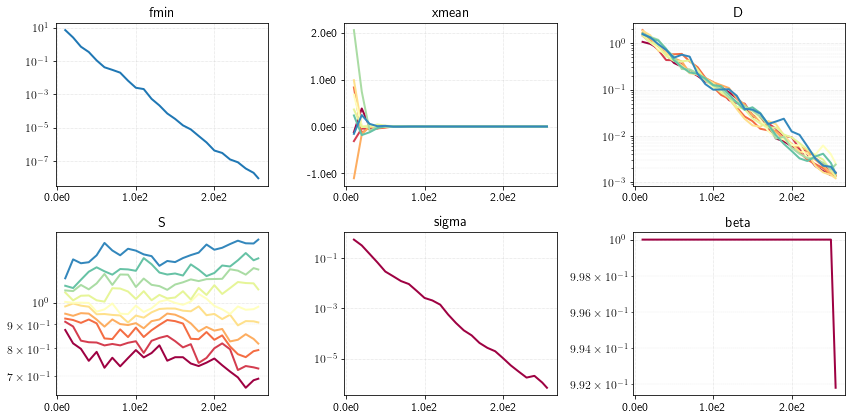

In [41]:
# 実行スクリプト
N = 10

def pnorm(x):
    p = 1
    f = np.sum(np.abs(x)**p, axis=1)**(1/p)
    return f

# Support for box constraint and periodic variables
# Set np.nan, -np.inf or np.inf if no bound
LOWER_BOUND = -5.0 * np.ones(N)
UPPER_BOUND = 5.0 * np.ones(N)
FLAG_PERIODIC = np.asarray([False] * N)
period_length = (UPPER_BOUND - LOWER_BOUND) * 2.0
period_length[FLAG_PERIODIC] /= 2.0
period_length[np.logical_not(np.isfinite(period_length))] = np.inf

def fobj(x):
    xx = mirror(x, LOWER_BOUND, UPPER_BOUND, FLAG_PERIODIC)
    return pnorm(xx)

# Setting for resart
NUM_RESTART = 10  # number of restarts with increased population size
MAX_NEVAL = 1e6   # maximal number of f-calls
F_TARGET = 1e-8   # target function value
total_neval = 0   # total number of f-calls

# Main loop
ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2.)
ddcma.upper_bounding_coordinate_std(period_length)
checker = Checker(ddcma)
logger = Logger(ddcma)
for restart in range(NUM_RESTART):        
    issatisfied = False
    fbestsofar = np.inf
    while not issatisfied:
        ddcma.onestep(func=fobj)
        ddcma.upper_bounding_coordinate_std(period_length)
        fbest = np.min(ddcma.arf)
        fbestsofar = min(fbest, fbestsofar)
        if fbest <= F_TARGET:
            issatisfied, condition = True, 'ftarget'
        else:
            issatisfied, condition = checker()
        if ddcma.t % 10 == 0:
            print(ddcma.t, ddcma.neval, fbest, fbestsofar)
            logger()
    logger(condition)
    print("Terminated with condition: " + str(condition))
    # For restart
    total_neval += ddcma.neval
    if total_neval < MAX_NEVAL and fbest > F_TARGET:
        popsize = ddcma.lam * 2
        ddcma = DdCma(xmean0=np.random.randn(N), sigma0=np.ones(N)*2., lam=popsize)
        checker = Checker(ddcma)
        logger.setcma(ddcma)
        print("Restart with popsize: " + str(ddcma.lam))
    else:
        break

# Produce a figure
fig, axdict = logger.plot()
for key in axdict:
    if key not in ('xmean'):
        axdict[key].set_yscale('log')
plt.tight_layout()
plt.savefig(logger.prefix + '.pdf')

#### まとめと対策
- 尖った等高線を持つ目的関数では探索に失敗することがある．特に，開き角度が$0$になるケースは注意．
- 多少の尖ったケースであれば，集団サイズを大きくすることで，対応可能です．集団サイズを大きくしながらリスタートする戦略を取っていれば，問題なく対応できる場合があります．ただし，定式化の段階で対応するに越したことはありません．
- 尖った等高線を持つ目的関数は，max や min，条件分岐がある場合に起こりやすい．可能であれば，max をなめらかな関数で近似するなどの工夫をしましょう．例えば，maxであればLogSumExp関数（$a > 0$）
$$
z_{\max} = \max(z_1, \dots, z_k) \approx \frac{1}{a} \log\left(\sum_{i=1}^{k} \exp(a z_i)\right) = z_{\max} + \frac{1}{a} \log\left(\sum_{i=1}^{k} \exp(a (z_i - z_\max))\right)
$$
であったり，Softmax関数を用いる方法が考えられます．
- 制約条件をペナルティ関数を用いて対処する場合も，尖った等高線を作り出しやすいので，注意が必要です．例えば，ある関数$g(x)$が$G$を超えてほしくない場合，$f(x) + c \max(g(x) - G, 0)$（$c$はペナルティ係数）といった方法がよく採用されますが，この場合も制約の境界上がなめらかでなくなる可能性があります．境界上の目的関数値が最適でない場合には，問題になりませんが，最適であるため境界上に収束することが必要になる場合には気をつけましょう．



## 4. 大域的多峰な目的関数

前述の通り，大域的多峰性を持つ関数の場合，最適化アルゴリズムサイドからアプローチしようとしても，集団サイズを大きくしても効果が無い，もしくは逆効果，となるため，初期値を変えながらリスタートを繰り返す力技に頼らざるを得ません．

この場合，目的関数の設計を工夫することで，

## その他のトピック

#### 制約条件の対処
制約と一言でいっても，使える情報や計算時間など，状況は多岐に渡ります．矩形制約などは標準的に対応されている場合が多いものの，それ以外の制約はペナルティ関数を使うなどが一般的に利用しやすいでしょう．ただし，ペナルティ係数の設定によっては非常に解きにくい問題になってしまう，最適解が制約を違反してしまう，などの困難さがつきまといます．制約条件の性質毎に適切な制約対処法が異なるため，性質を良く検討した上で制約対処法を選択しましょう．

#### シミュレーション条件の不確実性
目的関数は基本的にシミュレーションを通して計算されると想定していますが，シミュレーションの条件が予め一意に定まるとは限りません．例えば，タイヤの設計をしている場合，路面状態によってグリップ性能は変わるでしょう．その場合，特定の状況を想定して最適化しても，他の状況では良くない解を得てしまう可能性があります．また，現実環境の情報が不足しているため，シミュレーション条件がそもそも不確実である，という場面も想定されます．その場合，考え得る最悪ケースの性能を最適化する，などの方法があります．シミュレーション環境が不確実な場合には，そのようなロバスト最適化などを検討しましょう．

#### 実行時間
目的関数の評価回数（シミュレーション回数）が少ない場合，CMA-ESよりもNelder-Mead法などを用いた局所探索をしたほうが，良い解を得られる場合があることを述べました．しかし，目的関数の評価回数が少なければ，あくまで局所的な探索しかできないことも事実です．大域的な探索を行いたい場合，シミュレーションの精度を落として高速に計算できるようにする方法が考えられます．ただ，愚直にこれを実装すると，シミュレーション精度が悪いので探索結果の信頼性が損なわれます．これに対して，シミュレーション精度をコントロールしながら最適化を進めていく，マルチフィデリティ最適化，という方針があります．シミュレーション時間がネックでありCMA-ESを活用できない場合には，この方針を検討してみましょう．